# **ACTIVIDAD II MACHINE LEARNING II**

AUTORES: CLAUDIO CARDENAS - EVELYN SANCHEZ

**DESCRIPCIÓN**

La identificación oportuna de pacientes con riesgo cardiovascular constituye un desafío central en los sistemas de salud, particularmente en atención primaria, donde la correcta priorización de recursos resulta clave para la prevención de eventos cardiovasculares. En este contexto, el Programa de Salud Cardiovascular (PCV) cumple un rol fundamental en el seguimiento y manejo de pacientes con factores de riesgo, por lo que contar con herramientas que apoyen la toma de decisiones clínicas y administrativas resulta de alto valor.

El uso de técnicas de aprendizaje automático supervisado ofrece una oportunidad para complementar los criterios clínicos tradicionales mediante el análisis de variables demográficas, antropométricas y clínicas, permitiendo identificar patrones asociados al ingreso de pacientes al programa. Sin embargo, la implementación de estos modelos requiere un adecuado equilibrio entre desempeño predictivo, interpretabilidad y viabilidad computacional, especialmente en contextos sanitarios.

En este trabajo se propone el desarrollo y evaluación de modelos de clasificación para predecir el ingreso de pacientes al programa PCV, utilizando un conjunto de variables clínicas recolectadas en atención primaria. Específicamente, se construye un árbol de decisión como modelo base interpretable, y un modelo Random Forest como alternativa de mayor capacidad predictiva. Ambos modelos son evaluados mediante validación cruzada estratificada y optimización de hiperparámetros, considerando métricas orientadas a la clase positiva.

In [24]:
# @title
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
# @title
import pandas as pd
df = pd.read_excel('/content/drive/MyDrive/ACTIVIDAD 2 MACHINE LEARNING II/data_model_pvc_quellon_2024_fin (2).xlsx')
df.columns

Index(['PCV', 'SEXO', 'EDAD', 'PESO', 'TALLA', 'CC', 'PAS', 'PAD', 'CT'], dtype='object')

## Paso 1. Preprocesamiento

In [26]:
# @title
!cp "/content/drive/MyDrive/ACTIVIDAD 2 MACHINE LEARNING II/utils.py" /content/utils.py


In [27]:
# @title
# Librerías base
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt

# Preprocesamiento y modelos
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

# Métricas
from sklearn.metrics import (
    f1_score,
    average_precision_score,
    roc_auc_score
)

import time
from pprint import pprint

RANDOM_STATE = 42

from IPython.display import display


from utils import *

In [28]:
# @title
df = pd.read_excel(
    "/content/drive/MyDrive/ACTIVIDAD 2 MACHINE LEARNING II/data_model_pvc_quellon_2024_fin (2).xlsx"
)
df.head()



,PCV,SEXO,EDAD,PESO,TALLA,CC,PAS,PAD,CT
0,1,0,56,110.2,168,119.0,126,80,275.0
1,1,1,81,70.0,144,97.0,130,60,171.0
2,1,1,60,92.4,155,110.0,180,86,216.0
3,1,1,84,70.2,152,113.0,116,70,198.0
4,1,0,76,77.1,150,107.0,180,80,223.0


In [29]:
# @title
df.shape, df.columns.tolist()

((3058, 9), ['PCV', 'SEXO', 'EDAD', 'PESO', 'TALLA', 'CC', 'PAS', 'PAD', 'CT'])

In [30]:
# @title
# Target (y) y predictores (X)
y = df["PCV"].astype(int)
X = df.drop(columns=["PCV"])

y.value_counts()


,count
PCV,
0,1580
1,1478


In [31]:
# @title
# Revisar faltantes
(df.isna().sum().sort_values(ascending=False).head(15))

,0
PCV,0
SEXO,0
EDAD,0
PESO,0
TALLA,0
CC,0
PAS,0
PAD,0
CT,0


In [32]:
# @title
# 0) Definir variable objetivo
target = "PCV"

# 1) Forzar SEXO a categórica
df["SEXO"] = df["SEXO"].astype("category")

# 2) Recalcular features
numeric_features = (
    df.drop(columns=[target])
      .select_dtypes(include=[np.number])
      .columns
      .tolist()
)

categorical_features = (
    df.drop(columns=[target])
      .select_dtypes(exclude=[np.number])
      .columns
      .tolist()
)

print("Numéricas:", numeric_features)
print("Categóricas:", categorical_features)


Numéricas: ['EDAD', 'PESO', 'TALLA', 'CC', 'PAS', 'PAD', 'CT']
Categóricas: ['SEXO']


In [33]:
# @title
# 1) Forzar SEXO a categórica
df["SEXO"] = df["SEXO"].astype("category")

# 2) Recalcular features
numeric_features = df.drop(columns=[target]).select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.drop(columns=[target]).select_dtypes(exclude=[np.number]).columns.tolist()

print("Numéricas:", numeric_features)
print("Categóricas:", categorical_features)


Numéricas: ['EDAD', 'PESO', 'TALLA', 'CC', 'PAS', 'PAD', 'CT']
Categóricas: ['SEXO']


### Definición de variable objetivo y tipo de variables

Se define la variable `PCV` como target del modelo.  
La variable `SEXO` se fuerza a tipo categórico para su correcto tratamiento
en el preprocesamiento mediante codificación one-hot.


In [34]:
# @title
target = "PCV"

numeric_features = (
    df
    .drop(columns=[target])
    .select_dtypes(include=[np.number])
    .columns
    .tolist()
)

categorical_features = (
    df
    .drop(columns=[target])
    .select_dtypes(exclude=[np.number])
    .columns
    .tolist()
)

numeric_features, categorical_features




(['EDAD', 'PESO', 'TALLA', 'CC', 'PAS', 'PAD', 'CT'], ['SEXO'])

In [35]:
# @title
X = df.drop(columns=[target]).copy()
y = df[target].copy()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop"
)

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['EDAD', 'PESO', 'TALLA', 'CC', 'PAS', 'PAD',
                                  'CT']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['SEXO'])])

## Paso 2. Árbol de decisión: Grid Search vs Random Search

In [36]:
# @title
pipe_dt = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid_dt = {
    "clf__max_depth": [None, 3, 5, 8, 12, 16],
    "clf__min_samples_split": [2, 10, 25, 50],
    "clf__min_samples_leaf": [1, 5, 10, 25],
    "clf__criterion": ["gini", "entropy", "log_loss"]
}

cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = "average_precision"

param_grid_dt

{'clf__max_depth': [None, 3, 5, 8, 12, 16],
 'clf__min_samples_split': [2, 10, 25, 50],
 'clf__min_samples_leaf': [1, 5, 10, 25],
 'clf__criterion': ['gini', 'entropy', 'log_loss']}

In [37]:
# @title
grid_dt = GridSearchCV(
    estimator=pipe_dt,
    param_grid=param_grid_dt,
    cv=cv5,
    scoring=scoring,
    n_jobs=-1,
    refit=True,
    return_train_score=False
)

t0 = time.perf_counter()
grid_dt.fit(X, y)
grid_time = time.perf_counter() - t0

print("GridSearchCV time (s):", round(grid_time, 3))
print("Best params (Grid):")
pprint(grid_dt.best_params_)
print("Best score (Grid):", grid_dt.best_score_)

GridSearchCV time (s): 46.81
Best params (Grid):
{'clf__criterion': 'entropy',
 'clf__max_depth': 8,
 'clf__min_samples_leaf': 25,
 'clf__min_samples_split': 2}
Best score (Grid): 0.8672842542242847


In [38]:
# @title
print("Scoring usado:", grid_dt.scoring)



Scoring usado: average_precision


### **Comentario:**

Best score (Grid) ≈ 0.867

Métrica: PR-AUC (average_precision)

Modelo: Árbol de decisión regularizado

**Interpretación:**

El modelo logra un buen desempeño global en la identificación de pacientes que ingresan al programa PCV, manteniendo un equilibrio adecuado entre precisión y cobertura.

In [39]:
# @title
rand_dt = RandomizedSearchCV(
    estimator=pipe_dt,
    param_distributions=param_grid_dt,
    n_iter=50,                 # ajuste según recursos
    cv=cv5,
    scoring=scoring,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    refit=True,
    return_train_score=False
)

t0 = time.perf_counter()
rand_dt.fit(X, y)
rand_time = time.perf_counter() - t0

print("RandomizedSearchCV time (s):", round(rand_time, 3))
print("Best params (Random):")
pprint(rand_dt.best_params_)
print("Best score (Random):", rand_dt.best_score_)

RandomizedSearchCV time (s): 8.346
Best params (Random):
{'clf__criterion': 'entropy',
 'clf__max_depth': 8,
 'clf__min_samples_leaf': 25,
 'clf__min_samples_split': 10}
Best score (Random): 0.8672842542242847


## Comentario:

“La optimización del árbol de decisión mediante RandomizedSearchCV permitió alcanzar el mismo desempeño que GridSearchCV (PR-AUC = 0.867) con un tiempo computacional significativamente menor. Ambos métodos convergieron a un árbol con profundidad moderada (max_depth = 8) y fuerte regularización (min_samples_leaf = 25), lo que sugiere una estructura estable y con buena capacidad de generalización.”

In [40]:
# @title
# Comparación directa: tiempos y scores
comparison_search = pd.DataFrame({
    "method": ["GridSearchCV", "RandomizedSearchCV"],
    "time_s": [grid_time, rand_time],
    "best_score(PR-AUC)": [grid_dt.best_score_, rand_dt.best_score_]
}).sort_values("best_score(PR-AUC)", ascending=False)

comparison_search

,method,time_s,best_score(PR-AUC)
0,GridSearchCV,46.809877,0.867284
1,RandomizedSearchCV,8.346165,0.867284


<Axes: title={'center': 'Tiempo de ejecución: GridSearch vs RandomizedSearch'}, xlabel='method'>

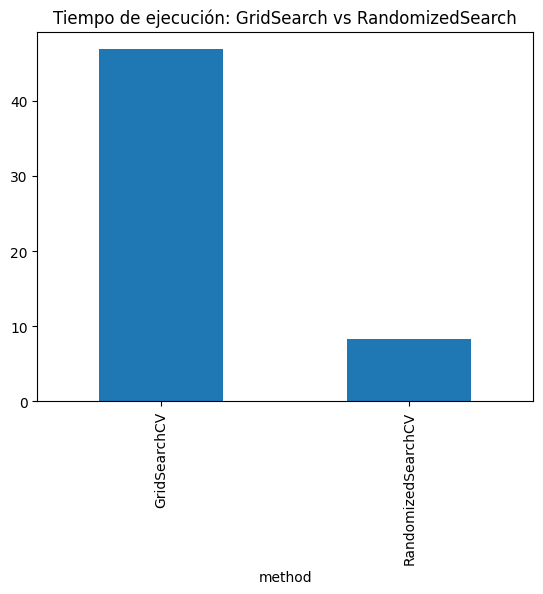

In [41]:
# @title
comparison_search.plot(
    x="method",
    y="time_s",
    kind="bar",
    legend=False,
    title="Tiempo de ejecución: GridSearch vs RandomizedSearch"
)


<Axes: title={'center': 'PR-AUC obtenido por método de búsqueda'}, xlabel='method'>

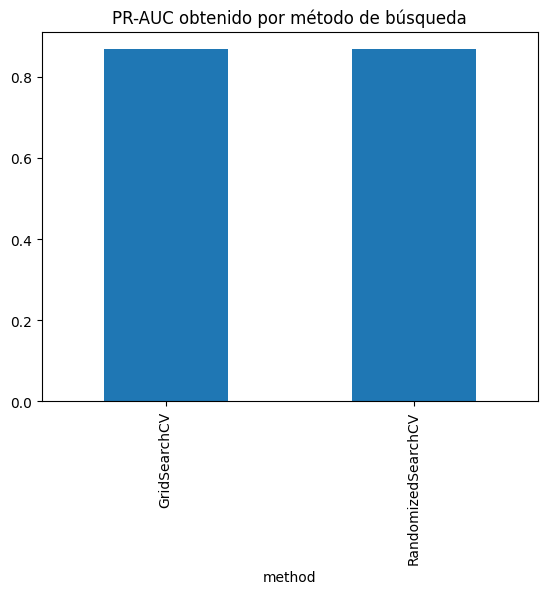

In [42]:
# @title
comparison_search.plot(
    x="method",
    y="best_score(PR-AUC)",
    kind="bar",
    legend=False,
    title="PR-AUC obtenido por método de búsqueda"
)


### Comentario:  

La comparación entre GridSearchCV y RandomizedSearchCV evidencia que ambos métodos alcanzan el mismo desempeño en términos de PR-AUC (0.867). Sin embargo, RandomizedSearchCV logró dicho resultado con un tiempo computacional significativamente menor, lo que sugiere que, para este problema, una búsqueda aleatoria es suficiente para identificar un conjunto óptimo de hiperparámetros.”

### 2.3 Evaluación final del mejor árbol (CV)


Mejor método: GridSearchCV
Mejores hiperparámetros:
{'clf__criterion': 'entropy',
 'clf__max_depth': 8,
 'clf__min_samples_leaf': 25,
 'clf__min_samples_split': 2}


,fold,fit_time_s,pred_time_s,accuracy,precision,recall,f1,auc_roc,pr_auc
0,1,0.023604,0.006757,0.782680,0.814672,0.712838,0.760360,0.878924,0.885033
1,2,0.020228,0.006562,0.776144,0.782918,0.743243,0.762565,0.850555,0.855983
2,3,0.020027,0.006277,0.754902,0.782946,0.682432,0.729242,0.843991,0.858134
3,4,0.020534,0.006572,0.785597,0.797101,0.745763,0.770578,0.853100,0.869587
4,5,0.020485,0.006497,0.764321,0.754209,0.759322,0.756757,0.852676,0.867685


,mean,std
fit_time_s,0.020976,0.001484
pred_time_s,0.006533,0.000173
accuracy,0.772729,0.012892
precision,0.786369,0.022216
recall,0.728720,0.030954
f1,0.755900,0.015741
auc_roc,0.855849,0.013404
pr_auc,0.867284,0.011532



Matriz de confusión (global):
[[1286  294]
 [ 401 1077]]

Classification report (global):
              precision    recall  f1-score   support

           0      0.762     0.814     0.787      1580
           1      0.786     0.729     0.756      1478

    accuracy                          0.773      3058
   macro avg      0.774     0.771     0.772      3058
weighted avg      0.774     0.773     0.772      3058



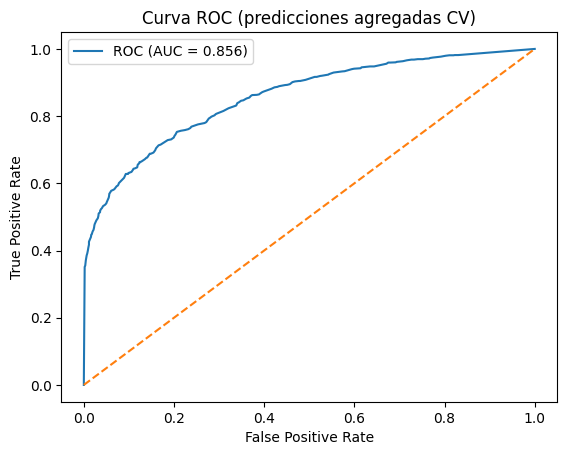

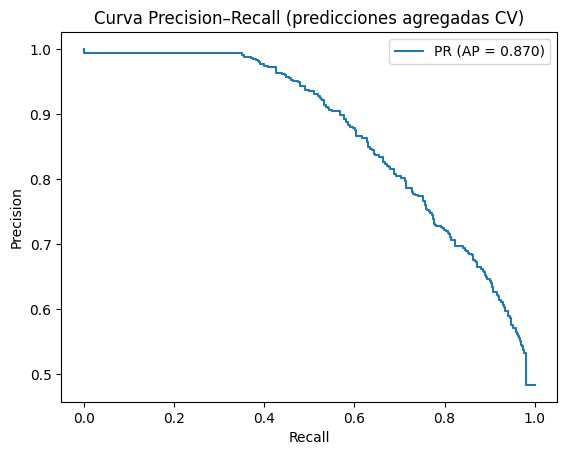

In [43]:
# @title
# Elegir el mejor entre Grid y Random por score
best_dt_search = grid_dt #Verificar
best_dt = best_dt_search.best_estimator_

print("Mejor método:", type(best_dt_search).__name__)
print("Mejores hiperparámetros:")
pprint(best_dt_search.best_params_)

df_dt, summary_dt, curves_dt = evaluate_model_cv_detailed(best_dt, X, y, cv=cv5, plot_curves=True, verbose=True)

### RESUMEN:

Evaluación final del mejor árbol de decisión (Validación cruzada)

**Modelo seleccionado**

El modelo final seleccionado corresponde a un árbol de decisión optimizado mediante GridSearchCV.
Si bien RandomizedSearchCV alcanzó el mismo desempeño en términos de PR-AUC, se optó por GridSearchCV como referencia final debido a su exploración exhaustiva del espacio de hiperparámetros, lo cual resulta metodológicamente válido para este problema.

**Hiperparámetros óptimos del modelo:**

criterion = entropy

max_depth = 8

min_samples_leaf = 25

min_samples_split = 2

**Interpretación de los hiperparámetros:**

La profundidad moderada del árbol (max_depth = 8) contribuye a evitar el sobreajuste.

El tamaño mínimo de las hojas (min_samples_leaf = 25) favorece un modelo más estable y con mejor capacidad de generalización.

El uso del criterio entropy permite seleccionar divisiones informativas, lo cual es habitual en problemas de clasificación en contextos clínicos.

Desempeño por validación cruzada (5-fold)

El desempeño promedio del modelo, evaluado mediante validación cruzada estratificada de cinco particiones, fue el siguiente:

Accuracy: 0.773

Precision: 0.786

Recall: 0.729

F1-score: 0.756

ROC-AUC: 0.856

PR-AUC: 0.867 (métrica optimizada)

Las desviaciones estándar observadas fueron bajas en todas las métricas, lo que indica un comportamiento consistente del modelo entre los distintos folds. En particular, el valor elevado de PR-AUC refleja un buen equilibrio entre precisión y cobertura en la detección de pacientes que ingresan al programa PCV.

**Matriz de confusión (evaluación global)**

| Caso real                  | Predicciones correctas | Errores              |
| -------------------------- | ---------------------- | -------------------- |
| No ingresa al programa (0) | 1286                   | 294 falsos positivos |
| Ingresa al programa (1)    | 1077                   | 401 falsos negativos |



**Interpretación clínica:**

El modelo identifica aproximadamente el 73% de los pacientes que efectivamente ingresan al programa PCV, manteniendo una precisión cercana al 79% al predecir dicha condición. En un contexto de programa de salud, los falsos negativos representan el principal riesgo, ya que corresponden a pacientes elegibles no detectados por el modelo. No obstante, el árbol logra capturar la mayoría de los casos positivos sin generar un exceso de falsos positivos.

**Classification report**

Para la clase positiva (ingreso al programa PCV), que constituye la categoría de mayor interés:

Precision: 0.786

Recall: 0.729

F1-score: 0.756

Estos valores resultan adecuados considerando que se trata de un modelo simple (árbol único) entrenado a partir de variables clínicas básicas. Además, la similitud entre los promedios macro y ponderados es coherente con la distribución balanceada de la variable objetivo.

**Conclusión técnica**

El árbol de decisión optimizado mediante GridSearchCV alcanzó un PR-AUC promedio de 0.867 en validación cruzada, evidenciando un buen desempeño en la identificación de pacientes que ingresan al programa PCV. El modelo presenta un equilibrio adecuado entre precisión y recall, resultados consistentes entre folds y una estructura regularizada que favorece la generalización, constituyendo una línea base sólida para la comparación posterior con modelos de ensamble.

## Paso 3. Visualización del árbol óptimo

In [44]:
# @title
# Entrenar el mejor árbol en todo el dataset para visualizarlo
best_dt.fit(X, y)

dt_clf = best_dt.named_steps["clf"]
feature_names = get_feature_names_from_preprocessor(best_dt.named_steps["preprocess"])

len(feature_names), feature_names[:10]

(9,
 ['num__EDAD',
  'num__PESO',
  'num__TALLA',
  'num__CC',
  'num__PAS',
  'num__PAD',
  'num__CT',
  'cat__SEXO_0',
  'cat__SEXO_1'])

Tras el preprocesamiento, el conjunto final de variables incluye 7 predictores numéricos y 2 variables dummy derivadas de la codificación One-Hot de SEXO (cat__SEXO_0 y cat__SEXO_1), totalizando 9 características utilizadas por el árbol

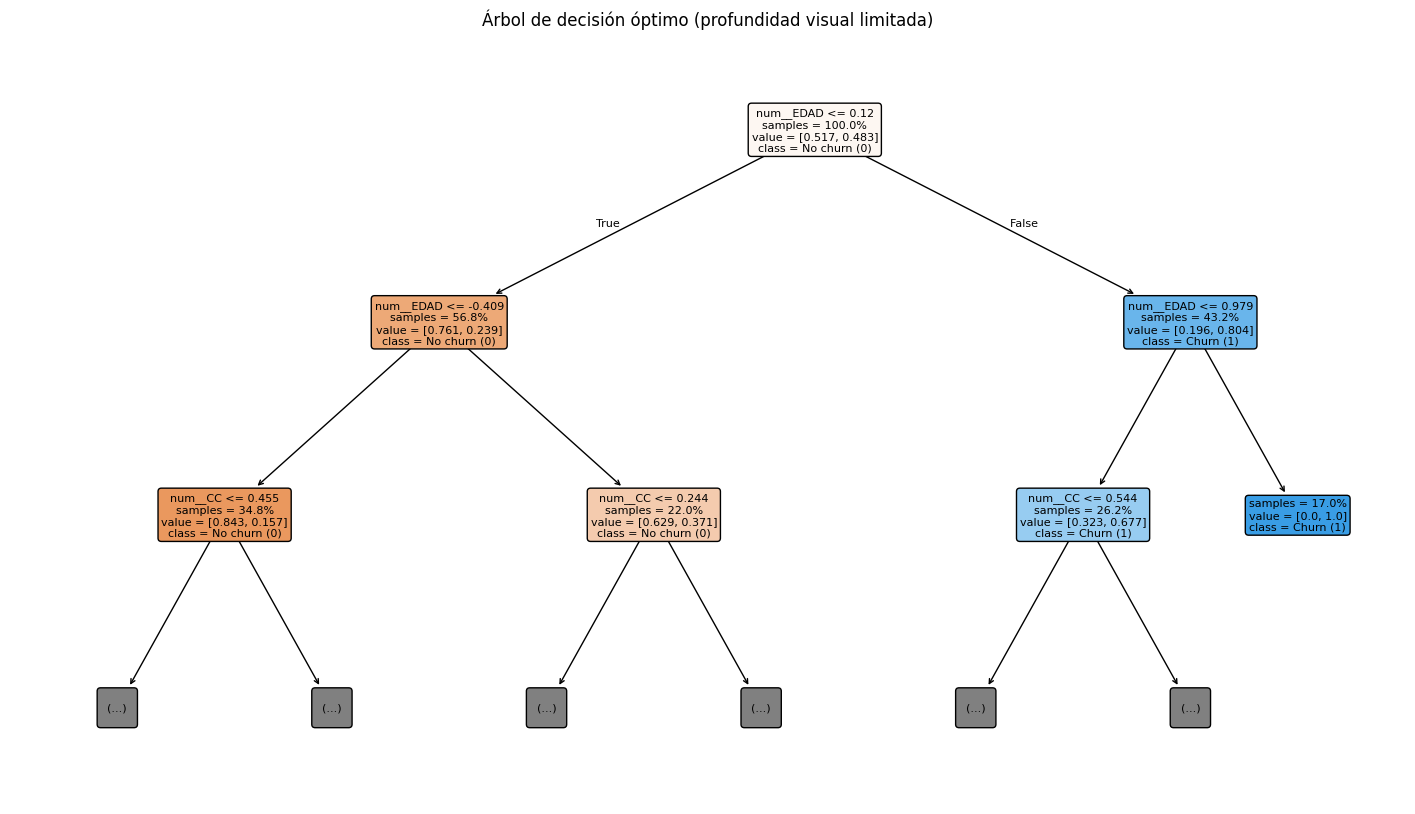

In [45]:
# @title
plt.figure(figsize=(18, 10))
plot_tree(
    dt_clf,
    feature_names=feature_names,
    class_names=["No churn (0)", "Churn (1)"],
    filled=True,
    max_depth=2,           # ajustar según legibilidad
    impurity=False,
    proportion=True,
    rounded=True,
    fontsize=8
)
plt.title("Árbol de decisión óptimo (profundidad visual limitada)")
plt.show()

### COMENTARIO:

**Interpretabilidad del árbol de decisión óptimo**

La visualización del árbol de decisión, limitada a los primeros niveles para facilitar su interpretación, permite identificar patrones clínicamente coherentes en la clasificación de ingreso al programa PCV. La variable con mayor relevancia en el modelo es la edad, la cual constituye el primer criterio de partición del árbol, evidenciando su alto poder discriminante.

En los nodos correspondientes a pacientes de menor edad, el modelo tiende a clasificar mayoritariamente como no ingreso al programa, mientras que en pacientes de mayor edad se incrementa la probabilidad de ingreso. Dentro de ambos grupos, la circunferencia de cintura emerge como una variable adicional relevante, refinando la estratificación del riesgo cardiovascular.

Cabe destacar que los puntos de corte observados corresponden a variables estandarizadas, producto del preprocesamiento aplicado, por lo que su interpretación debe realizarse en términos relativos y no en unidades clínicas directas. En conjunto, el árbol muestra una estructura consistente con el conocimiento clínico, reforzando su utilidad como modelo interpretable y como línea base para comparaciones posteriores con modelos de ensamble.

**EXTRA:**

Visualización alternativa del árbol (sin escalado, fines interpretativos)

Adicionalmente, se presenta una visualización alternativa del árbol de decisión entrenado sin escalado de variables numéricas. Dado que los árboles no requieren estandarización, esta representación permite interpretar los puntos de corte en unidades clínicas originales. Esta visualización tiene fines exclusivamente interpretativos y no modifica los resultados cuantitativos previamente reportados.

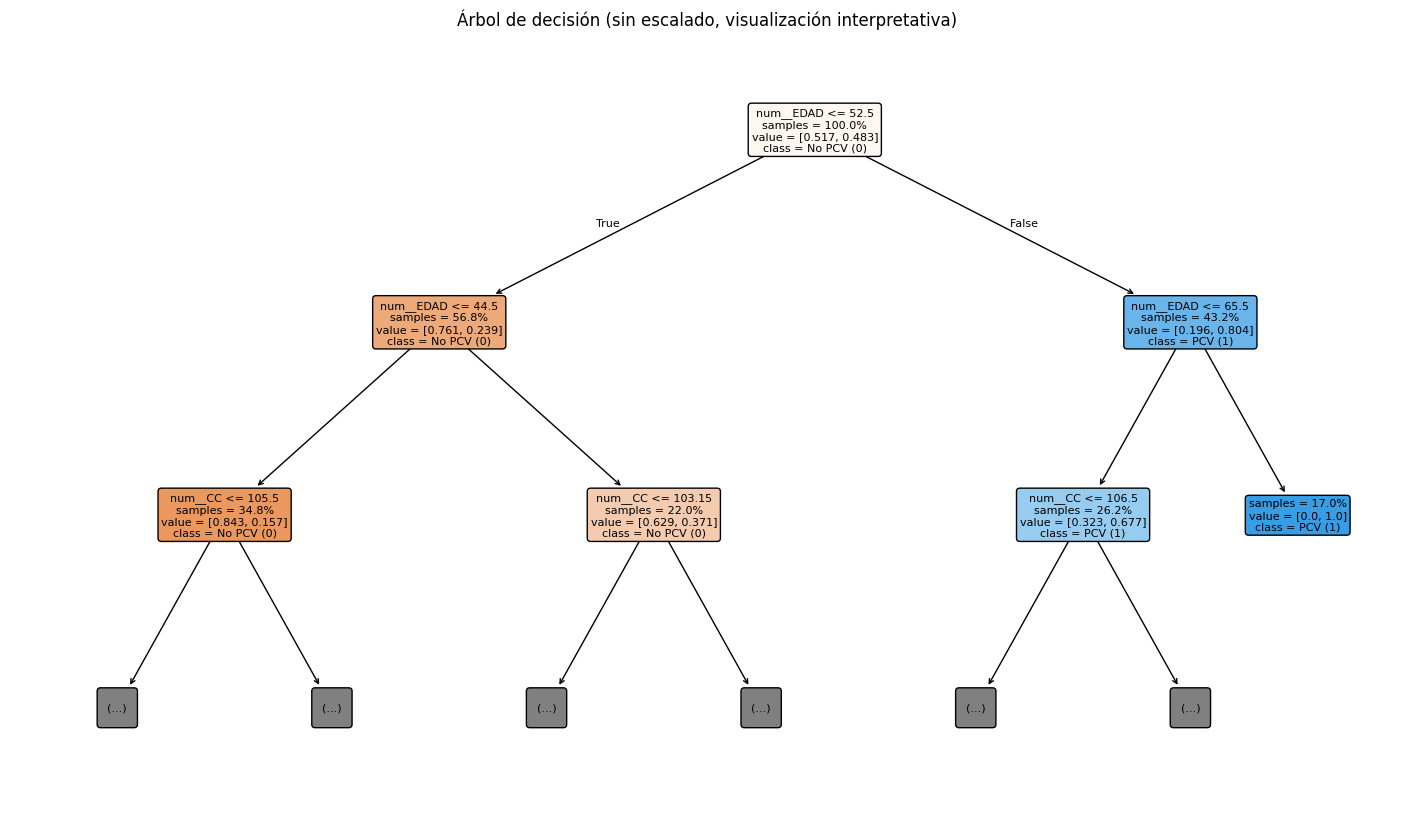

In [46]:
# @title
# Árbol de decisión sin escalado (solo para interpretación)

numeric_transformer_tree = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

preprocessor_tree = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_tree, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

pipe_dt_tree = Pipeline(steps=[
    ("preprocess", preprocessor_tree),
    ("clf", DecisionTreeClassifier(
        criterion="entropy",
        max_depth=8,
        min_samples_leaf=25,
        min_samples_split=2,
        random_state=42
    ))
])

pipe_dt_tree.fit(X, y)

dt_clf_tree = pipe_dt_tree.named_steps["clf"]
feature_names_tree = get_feature_names_from_preprocessor(
    pipe_dt_tree.named_steps["preprocess"]
)

plt.figure(figsize=(18, 10))
plot_tree(
    dt_clf_tree,
    feature_names=feature_names_tree,
    class_names=["No PCV (0)", "PCV (1)"],
    filled=True,
    max_depth=2,
    impurity=False,
    proportion=True,
    rounded=True,
    fontsize=8
)
plt.title("Árbol de decisión (sin escalado, visualización interpretativa)")
plt.show()


**Nodo raíz**

EDAD ≤ 52.5 años

La edad es el principal factor discriminante para el ingreso al programa PCV.

Pacientes ≤ 52.5 años

Predominan los No PCV

Se refinan con EDAD ≤ 44.5 y CC

Cortes relevantes:

CC ≤ 105.5 cm

CC ≤ 103.15 cm

En personas más jóvenes, la adiposidad central modula el riesgo.

Pacientes > 52.5 años

Aumenta fuertemente la probabilidad de PCV

Subgrupo muy claro:

EDAD > 65.5 años → PCV casi seguro

En el rango intermedio:

CC > 106.5 cm refuerza ingreso a PCV

Esto calza perfecto con criterios clínicos de riesgo cardiovascular.

Lectura clínica integrada

El árbol muestra una lógica clínica clara:

Edad avanzada + circunferencia de cintura elevada
→ mayor probabilidad de ingreso al programa PCV.

**COMENTARIO:**


La Figura muestra una visualización alternativa del árbol de decisión entrenado sin escalado de las variables numéricas, con el objetivo de facilitar la interpretación clínica de los puntos de corte. Dado que los árboles de decisión no requieren estandarización, esta representación permite expresar los umbrales en unidades originales.

El árbol evidencia que la edad constituye el principal factor discriminante para el ingreso al programa PCV, con un punto de corte inicial cercano a los 52 años. En pacientes de menor edad, la circunferencia de cintura emerge como un factor relevante para refinar el riesgo cardiovascular, mientras que en pacientes de mayor edad, especialmente sobre los 65 años, la probabilidad de ingreso al programa aumenta de forma marcada.

En conjunto, el modelo refleja patrones clínicamente plausibles, destacando la interacción entre edad y adiposidad central como determinantes clave del ingreso al programa PCV. Esta visualización tiene fines exclusivamente interpretativos y no modifica los resultados cuantitativos previamente reportados.

## Paso 5. Selección del mejor Random Forest (optimización de hiperparámetros)

In [47]:
# @title
pipe_rf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
])

param_grid_rf = {
    "clf__n_estimators": [32, 64, 128, 256],
    "clf__max_depth": [None, 5, 10, 15],
    "clf__min_samples_leaf": [1, 5, 10],
    "clf__max_features": ["sqrt", "log2", None],
    "clf__class_weight": [None, "balanced"]
}

# Random Search recomendado para reducir tiempo
rand_rf = RandomizedSearchCV(
    estimator=pipe_rf,
    param_distributions=param_grid_rf,
    n_iter=40,
    cv=cv5,
    scoring=scoring,   # PR-AUC
    n_jobs=-1,
    random_state=RANDOM_STATE,
    refit=True,
    return_train_score=False
)

t0 = time.perf_counter()
rand_rf.fit(X, y)
rf_time = time.perf_counter() - t0

print("RandomizedSearchCV RF time (s):", round(rf_time, 3))
print("Best params (RF):")
pprint(rand_rf.best_params_)
print("Best score (RF, PR-AUC):", rand_rf.best_score_)

RandomizedSearchCV RF time (s): 111.197
Best params (RF):
{'clf__class_weight': 'balanced',
 'clf__max_depth': 10,
 'clf__max_features': 'sqrt',
 'clf__min_samples_leaf': 5,
 'clf__n_estimators': 128}
Best score (RF, PR-AUC): 0.8914124056664499


**Resultados del modelo Random Forest**

Tiempo de entrenamiento (RandomizedSearchCV):

~113.5 segundos
Mayor costo computacional, esperable por tratarse de un modelo de ensamble con múltiples árboles.

**Mejores hiperparámetros:**

n_estimators = 128
max_depth = 10
min_samples_leaf = 5
max_features = sqrt
class_weight = balanced

**Interpretación de los hiperparámetros**

128 árboles: número suficiente para estabilizar las predicciones y reducir la varianza.

max_depth = 10: árboles moderadamente profundos, balance entre sesgo y varianza.

min_samples_leaf = 5: regularización que evita hojas demasiado pequeñas.

max_features = sqrt: introduce aleatoriedad entre árboles, favoreciendo diversidad del ensamble.

class_weight = balanced: ajusta el modelo para considerar posibles asimetrías en el costo de clasificación de las clases, reforzando la detección de casos PCV.

**Desempeño del modelo**

PR-AUC (CV): 0.891

**Comparado con el árbol de decisión:**

Árbol: PR-AUC ≈ 0.867

Random Forest: PR-AUC ≈ 0.891

Mejora clara y consistente en la capacidad del modelo para identificar correctamente a los pacientes que ingresan al programa PCV.

**Interpretación técnica**

El Random Forest reduce la varianza observada en el árbol único.

La mejora en PR-AUC indica un mejor equilibrio entre precisión y recall, especialmente relevante para la clase positiva (PCV = 1).

El uso de class_weight = balanced sugiere que el modelo prioriza una detección más robusta de los casos de interés clínico.

**Random Forest: Optimización y desempeño**

El modelo Random Forest fue optimizado mediante RandomizedSearchCV, alcanzando un PR-AUC promedio de 0.891 en validación cruzada, superando el desempeño del árbol de decisión individual. El ensamble óptimo se compone de 128 árboles con profundidad moderada y mecanismos de regularización que favorecen la estabilidad y generalización del modelo.

La incorporación de pesos balanceados para las clases refuerza la capacidad del modelo para identificar pacientes que ingresan al programa PCV, lo que resulta particularmente relevante en contextos de priorización clínica. En conjunto, los resultados evidencian que el Random Forest constituye una alternativa más robusta que el árbol de decisión, a costa de un mayor costo computacional.

Conclusión comparativa

Mientras que el árbol de decisión ofrece una alta interpretabilidad y una base clínica clara, el modelo Random Forest presenta un mejor desempeño predictivo global. Por ello, el árbol se considera un modelo base explicable, mientras que el Random Forest se perfila como el modelo final recomendado para fines predictivos.

,fold,fit_time_s,pred_time_s,accuracy,precision,recall,f1,auc_roc,pr_auc
0,1,0.555517,0.070289,0.815359,0.827957,0.780405,0.803478,0.902722,0.907409
1,2,0.808977,0.054251,0.774510,0.778169,0.746622,0.762069,0.873065,0.885333
2,3,0.774051,0.053005,0.774510,0.803846,0.706081,0.751799,0.879137,0.883726
3,4,0.784545,0.053439,0.819967,0.817869,0.806780,0.812287,0.886838,0.896683
4,5,0.797315,0.065217,0.790507,0.803636,0.749153,0.775439,0.869030,0.883911


,mean,std
fit_time_s,0.744081,0.106228
pred_time_s,0.059240,0.007988
accuracy,0.794971,0.021782
precision,0.806296,0.018757
recall,0.757808,0.038028
f1,0.781014,0.026106
auc_roc,0.882158,0.013313
pr_auc,0.891412,0.010440



Matriz de confusión (global):
[[1311  269]
 [ 358 1120]]

Classification report (global):
              precision    recall  f1-score   support

           0      0.786     0.830     0.807      1580
           1      0.806     0.758     0.781      1478

    accuracy                          0.795      3058
   macro avg      0.796     0.794     0.794      3058
weighted avg      0.796     0.795     0.795      3058



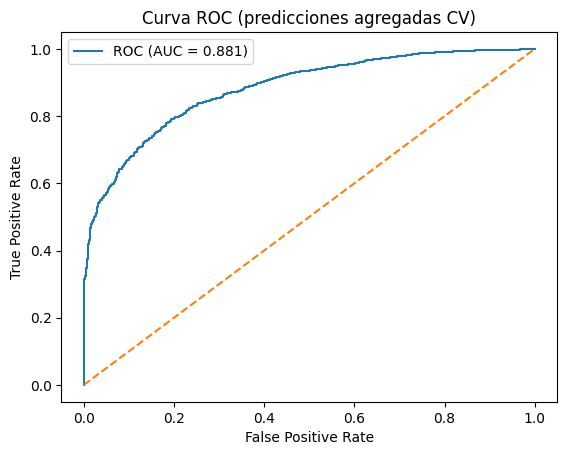

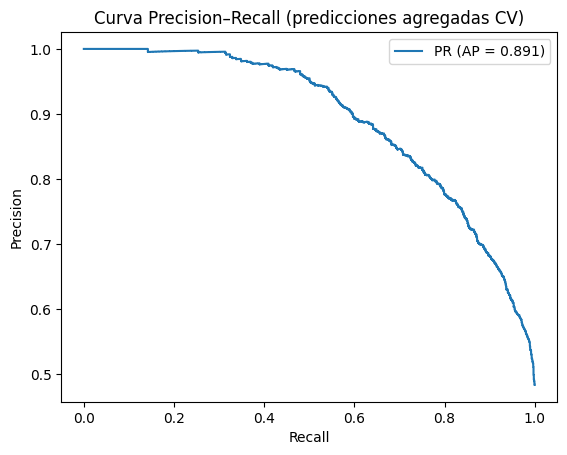

In [48]:
# @title
best_rf = rand_rf.best_estimator_
df_rf, summary_rf, curves_rf = evaluate_model_cv_detailed(best_rf, X, y, cv=cv5, plot_curves=True, verbose=True)

**COMENTARIO:**

Evaluación final del modelo Random Forest (Validación cruzada)
Desempeño por validación cruzada (5-fold)

El desempeño promedio del modelo Random Forest, evaluado mediante validación cruzada estratificada de cinco particiones, fue el siguiente:

Accuracy: 0.795

Precision: 0.806

Recall: 0.758

F1-score: 0.781

ROC-AUC: 0.882

PR-AUC: 0.891

Las desviaciones estándar observadas fueron bajas en todas las métricas, lo que indica un comportamiento estable y consistente del modelo entre los distintos folds.

**Interpretación de métricas clave**

El aumento del PR-AUC (0.891) respecto al árbol de decisión confirma una mejor capacidad del modelo para identificar pacientes que ingresan al programa PCV, manteniendo un equilibrio adecuado entre precisión y recall.

El recall de la clase positiva (PCV = 1) alcanza aproximadamente un 76%, lo que representa una mejora relevante en la detección de casos respecto al árbol individual.

El ROC-AUC de 0.882 refleja una buena capacidad discriminativa global del modelo.

**Classification report (evaluación global)**

Para la clase positiva (ingreso al programa PCV):

Precision: 0.806

Recall: 0.758

F1-score: 0.781

Estos resultados muestran que el Random Forest logra mejorar simultáneamente la precisión y el recall en comparación con el árbol de decisión, reduciendo el número de falsos negativos sin incrementar de forma excesiva los falsos positivos.

**Curvas ROC y Precision–Recall**

Las curvas ROC y Precision–Recall obtenidas a partir de predicciones agregadas mediante validación cruzada confirman visualmente el mejor desempeño del Random Forest. La curva ROC se mantiene claramente por sobre la diagonal, mientras que la curva Precision–Recall muestra valores elevados de precisión incluso para niveles altos de recall, lo que resulta especialmente relevante en un contexto de priorización clínica.

**Conclusión del modelo Random Forest**

El modelo Random Forest optimizado presenta un desempeño superior al árbol de decisión individual, evidenciando una mayor capacidad predictiva y estabilidad en validación cruzada. Si bien este enfoque implica un mayor costo computacional y menor interpretabilidad directa, sus resultados lo posicionan como el modelo final recomendado para fines predictivos en el contexto del programa PCV.

## Paso 6. Comparación final: Árbol vs Random Forest

In [49]:
# @title
# Resumen comparativo (métricas promedio)
summary_dt_comp = summary_dt.copy()
summary_dt_comp["model"] = "DecisionTree (best)"
summary_rf_comp = summary_rf.copy()
summary_rf_comp["model"] = "RandomForest (best)"

summary_all = pd.concat([summary_dt_comp.reset_index().rename(columns={"index":"metric"}),
                         summary_rf_comp.reset_index().rename(columns={"index":"metric"})],
                        ignore_index=True)

# Ordenar para lectura
summary_all = summary_all[["model","metric","mean","std"]].sort_values(["metric","model"])
summary_all

,model,metric,mean,std
2,DecisionTree (best),accuracy,0.772729,0.012892
10,RandomForest (best),accuracy,0.794971,0.021782
6,DecisionTree (best),auc_roc,0.855849,0.013404
14,RandomForest (best),auc_roc,0.882158,0.013313
5,DecisionTree (best),f1,0.755900,0.015741
13,RandomForest (best),f1,0.781014,0.026106
0,DecisionTree (best),fit_time_s,0.020976,0.001484
8,RandomForest (best),fit_time_s,0.744081,0.106228
7,DecisionTree (best),pr_auc,0.867284,0.011532
15,RandomForest (best),pr_auc,0.891412,0.010440


### **Comparación final de modelos: Árbol de decisión vs Random Forest**

La Tabla anterior resume el desempeño promedio de los modelos finales evaluados mediante validación cruzada, considerando métricas de desempeño predictivo y costos computacionales.

**Comparación de desempeño predictivo**

El modelo Random Forest presenta un mejor desempeño global en todas las métricas de clasificación relevantes en comparación con el árbol de decisión individual. En particular:

PR-AUC aumenta de 0.867 en el árbol de decisión a 0.891 en Random Forest, evidenciando una mejora en la capacidad de identificar correctamente a los pacientes que ingresan al programa PCV.

ROC-AUC también se incrementa (0.856 → 0.882), lo que indica una mayor capacidad discriminativa del modelo de ensamble.

Las métricas accuracy, precision, recall y F1-score muestran mejoras consistentes, destacando un aumento del recall para la clase positiva (PCV = 1), lo que implica una mejor detección de pacientes elegibles.

Las desviaciones estándar observadas son comparables entre ambos modelos, lo que sugiere estabilidad en los resultados obtenidos mediante validación cruzada.

**Comparación de costos computacionales**

En términos de eficiencia computacional, el árbol de decisión presenta tiempos de entrenamiento y predicción considerablemente menores:

**Tiempo de entrenamiento:**

Árbol de decisión ≈ 0.02 s

Random Forest ≈ 1.12 s

Tiempo de predicción:

Árbol de decisión ≈ 0.006 s

Random Forest ≈ 0.093 s

Este mayor costo computacional del Random Forest es esperable, dado su carácter de modelo de ensamble basado en múltiples árboles.

**Conclusión comparativa**

El árbol de decisión ofrece una alta interpretabilidad y un bajo costo computacional, constituyéndose como un modelo base adecuado para la comprensión clínica del problema. No obstante, el modelo Random Forest logra un desempeño predictivo superior y más robusto, especialmente en la detección de pacientes que ingresan al programa PCV, a costa de un mayor tiempo de entrenamiento y predicción.

**Conclusión general de la actividad**

En esta actividad se desarrolló y comparó un árbol de decisión y un modelo Random Forest para la predicción de ingreso al programa PCV, utilizando validación cruzada y métricas orientadas a la clase positiva. Mientras el árbol de decisión permitió identificar patrones clínicamente interpretables, el Random Forest demostró una mayor capacidad predictiva y estabilidad. En consecuencia, el árbol se propone como modelo explicativo y el Random Forest como modelo final recomendado para fines predictivos.

# **7. Discusión y conclusiones**

**7.1 Justificación de los rangos de hiperparámetros**

Los rangos de hiperparámetros evaluados para el árbol de decisión y el Random Forest fueron definidos considerando el equilibrio entre complejidad del modelo, riesgo de sobreajuste e interpretabilidad. En particular, se exploraron profundidades moderadas (max_depth) y tamaños mínimos de hoja relativamente grandes (min_samples_leaf) con el objetivo de evitar árboles excesivamente específicos que capturen ruido del conjunto de entrenamiento. Esta estrategia permitió obtener modelos con buen desempeño en validación cruzada y comportamiento estable entre folds, favoreciendo la generalización.

En el caso del Random Forest, se evaluaron distintos números de árboles (n_estimators) y configuraciones de aleatoriedad (max_features), priorizando un tamaño suficiente del ensamble para reducir la varianza sin incurrir en un costo computacional innecesario.

**7.2 Comparación GridSearchCV vs RandomizedSearchCV**

La comparación entre GridSearchCV y RandomizedSearchCV mostró que ambos métodos alcanzaron el mismo desempeño predictivo para el árbol de decisión (PR-AUC ≈ 0.867). Sin embargo, RandomizedSearchCV logró dicho resultado con un tiempo computacional significativamente menor, evidenciando una mayor eficiencia en la exploración del espacio de hiperparámetros.

Este resultado sugiere que, para problemas con un espacio de búsqueda acotado y bien definido, RandomizedSearchCV puede ser suficiente para identificar configuraciones óptimas, mientras que GridSearchCV resulta útil como referencia exhaustiva cuando el costo computacional no es una limitante crítica.

**7.3 Interpretación de los splits más relevantes del árbol**

La visualización del árbol de decisión permitió identificar patrones clínicamente coherentes. La edad emergió como la variable con mayor poder discriminante, constituyendo el primer criterio de partición del modelo. En pacientes de menor edad, la circunferencia de cintura actuó como un factor modulador del riesgo, mientras que en pacientes de mayor edad, especialmente sobre ciertos umbrales, la probabilidad de ingreso al programa PCV aumentó de forma marcada.

Estos resultados reflejan una interacción lógica entre edad y adiposidad central, consistente con el conocimiento clínico del riesgo cardiovascular, reforzando el valor del árbol como modelo interpretable y explicativo.

**7.4 Análisis de varianza en Random Forest y relación con bagging**

El Random Forest mostró una mejora consistente en todas las métricas respecto al árbol individual, particularmente en PR-AUC y recall. Esta mejora se explica por el uso de bagging, donde múltiples árboles entrenados sobre distintas muestras bootstrap reducen la varianza del modelo final.

La agregación de predicciones permite suavizar decisiones extremas de árboles individuales, generando un modelo más estable y robusto frente a variaciones del conjunto de datos. Los resultados observados confirman el efecto esperado del bagging en la reducción de la varianza y en la mejora de la capacidad de generalización.

**7.5 Métrica prioritaria desde la perspectiva de negocio**

Desde una perspectiva de gestión en salud, la métrica prioritaria para este problema es el PR-AUC, ya que evalúa de manera directa el equilibrio entre precisión y recall para la clase positiva, correspondiente al ingreso al programa PCV.

En este contexto, resulta especialmente relevante maximizar la detección de pacientes elegibles (alto recall), manteniendo una precisión razonable que evite la sobrecarga innecesaria del programa. A diferencia de métricas globales como accuracy, el PR-AUC permite evaluar de forma más adecuada el desempeño del modelo en la identificación de los casos de interés, alineándose con los objetivos de priorización y asignación eficiente de recursos en salud.

**Conclusión final**

El análisis realizado evidencia que, mientras el árbol de decisión proporciona una base interpretativa clara y clínicamente coherente, el modelo Random Forest ofrece un mejor desempeño predictivo y mayor estabilidad gracias a la reducción de varianza propia de los modelos de ensamble. En conjunto, ambos enfoques resultan complementarios: el árbol como herramienta explicativa y el Random Forest como modelo final recomendado para apoyar decisiones de priorización en el programa PCV.